# Water Allocation Simulation Analysis
This notebook provides tools to analyze the results of the water allocation simulation
across multiple scenarios, focusing on ecological and economic impacts under different
conditions.

## Overview
The simulation tests water allocation policies across various scenarios with different:
- River basins (station configurations)
- Actor compositions
- Water scarcity levels
- Forecast error profiles (bias and uncertainty)

The analysis evaluates how these factors affect both ecological integrity and economic benefits.


In this notebook we will:
1. Run the set of evaluation scenarios varying station size, scarcity level,  
   forecast bias and uncertainty.
2. Collect ecological and economic impact metrics for each run.
3. Visualize trade-offs and explore how model parameters influence outcomes.

In [7]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from types import MethodType
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import src.scenarios as sc
import src.plot_multi_analysis as pma
from src.optim import EvolutionnarySearch
import random

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [8]:
import copy

def cumul_incentive_policy(
    self,
    actions: np.ndarray,
    actors_priority: np.ndarray,
    avg_incomes: np.ndarray,
    water_pump: np.ndarray,
    avg_pump: np.ndarray,
    is_crisis: np.ndarray,
    water_flows: np.ndarray,
    quota: np.ndarray,
    DOE=15,
    DCR=10,
) -> np.ndarray:

    class CrisisLevel:
        NORMAL = -1.0
        ALERT = 0.0
        CRISIS = 1.0
        EXTREME_CRISIS = 2.0

    # Manual copy of incentive variant
    # This make the code bigger but also limit repetition problems
    if DOE == 0.1 and DCR == 0.05:
        # Hard coded params to avoid any problems
        # Scenario 0 optim results
        params = {
            "PF": 0.923169746128622,
            "PG": 3.134280569167306,
            "WF_EF": 0.5249153269703366,
            "PUR": 1.3654859762448144,
            "SUB_BC": 1.2762318960146912,
            "FIN_BC": 0.23665103851503674,
            "WF_SF": 2.929036282337239,
            "ANT_C_F": 0.07719003050635477,
            "ANT_N_F": 0.10005576673596114,
            "CF": 1.7691822513316218,
            "CG": 0.1902360535111736,
        }

        fine = np.zeros(self.nb_actors)
        crisis_level = is_crisis[-1]  # Current crisis level

        # If average income is negative, replace it with 0
        avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)

        # Defining a custom treshold that represent an anticipation crisis point based on DCR multiple
        critical_overall_demand_treshold = params["WF_SF"] * DCR

        # Copy to avoid reference use
        priority_factor = copy.copy(actors_priority)

        priority_factor[priority_factor == 2] = params["PF"]
        priority_factor[priority_factor == 1] = params["PF"] - 1.8 ** params["PG"]
        priority_factor[priority_factor == 0] = params["PF"] - 2.5 ** params["PG"]

        # As the simulation penalizes less subsidies we push more on it than fines
        SUBSIDY = -(
            # We make 5 times bigger subsidy as the simulation penalize 5 times less
            # So our politics align with the game rules and prefer pushing coop through subsidies rather than fines
            (DCR * params["SUB_BC"])
            * (1 / priority_factor)
        )

        FINE = (avg_incomes * params["FIN_BC"]) * (1 / priority_factor)

        exceding_quota_idx = water_pump > quota
        respecting_quota_idx = water_pump <= quota

        if (
            water_flows[-1] < critical_overall_demand_treshold
            and crisis_level == CrisisLevel.NORMAL
        ):
            # We anticipate a near crisis situation so we start applying fines
            # But it won't be as strong as in a real crisis

            fine[exceding_quota_idx] = FINE[exceding_quota_idx] * params["ANT_C_F"]
            fine[respecting_quota_idx] = (
                SUBSIDY[respecting_quota_idx] * params["ANT_C_F"]
            )
        else:

            match crisis_level:
                case CrisisLevel.NORMAL:
                    fine[exceding_quota_idx] = (
                        FINE[exceding_quota_idx] * params["ANT_N_F"]
                    )
                    fine[respecting_quota_idx] = (
                        SUBSIDY[respecting_quota_idx] * params["ANT_N_F"]
                    )
                    return fine

                case (
                    CrisisLevel.ALERT | CrisisLevel.CRISIS | CrisisLevel.EXTREME_CRISIS
                ):

                    if crisis_level == CrisisLevel.ALERT:
                        crisis_factor = params["CF"]
                    elif crisis_level == CrisisLevel.CRISIS:
                        crisis_factor = params["CF"] + params["CG"]
                    elif crisis_level == CrisisLevel.EXTREME_CRISIS:
                        crisis_factor = params["CF"] + 2 * params["CG"]
                    else:
                        print("WTF happening ?")
                        print("crisis_level", crisis_level)

                    actors_priority_below_crisis = actors_priority < crisis_level
                    actors_priority_above_crisis = actors_priority >= crisis_level

                    # Defectors
                    # Below priority and exceeding
                    actors_exceding_and_below_priority_idx = (
                        actors_priority_below_crisis == exceding_quota_idx
                    )
                    fine[actors_exceding_and_below_priority_idx] = (
                        FINE[actors_exceding_and_below_priority_idx]
                        * params["PF"]
                        * crisis_factor
                    )
                    # Above priority and exceeding
                    actors_exceding_and_above_priority_idx = (
                        actors_priority_above_crisis == exceding_quota_idx
                    )
                    fine[actors_exceding_and_above_priority_idx] = FINE[
                        actors_exceding_and_above_priority_idx
                    ]

                    # Cooperators
                    # Below priority and respecting
                    actors_respecting_and_below_priority_idx = (
                        actors_priority_below_crisis == respecting_quota_idx
                    )
                    fine[actors_respecting_and_below_priority_idx] = (
                        SUBSIDY[actors_respecting_and_below_priority_idx]
                        * params["PF"]
                        * crisis_factor
                    )
                    # Above priority and respecting
                    actors_respecting_and_above_priority_idx = (
                        actors_priority_above_crisis == respecting_quota_idx
                    )
                    fine[actors_respecting_and_above_priority_idx] = SUBSIDY[
                        actors_respecting_and_above_priority_idx
                    ]

                    return fine
        return fine

    else:
        # Scenario 1 optim results
        params = {
            "PF": 0.7266145696974551,
            "PG": 2.6016120263569538,
            "WF_EF": 0.865856531031441,
            "PUR": 0.9356609489016493,
            "SUB_BC": 3.2893318082328054,
            "FIN_BC": 0.060952784906565874,
            "WF_SF": 6.542628748726632,
            "ANT_C_F": 0.3005462481260572,
            "ANT_N_F": 0.0505896421462025,
            "CF": 1.519040171862454,
            "CG": 0.10856140246914334,
        }

        fine = np.zeros(self.nb_actors)
        crisis_level = is_crisis[-1]  # Current crisis level

        # If average income is negative, replace it with 0
        avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)

        # Defining a custom treshold that represent an anticipation crisis point based on DCR multiple
        critical_overall_demand_treshold = params["WF_SF"] * DCR

        # Copy to avoid reference use
        priority_factor = copy.copy(actors_priority)

        priority_factor[priority_factor == 2] = params["PF"]
        priority_factor[priority_factor == 1] = params["PF"] - 1.8 ** params["PG"]
        priority_factor[priority_factor == 0] = params["PF"] - 2.5 ** params["PG"]

        # As the simulation penalizes less subsidies we push more on it than fines
        SUBSIDY = -(
            # We make 5 times bigger subsidy as the simulation penalize 5 times less
            # So our politics align with the game rules and prefer pushing coop through subsidies rather than fines
            (DCR * params["SUB_BC"])
            * (1 / priority_factor)
        )

        FINE = (avg_incomes * params["FIN_BC"]) * (1 / priority_factor)

        exceding_quota_idx = water_pump > quota
        respecting_quota_idx = water_pump <= quota

        if (
            water_flows[-1] < critical_overall_demand_treshold
            and crisis_level == CrisisLevel.NORMAL
        ):
            # We anticipate a near crisis situation so we start applying fines
            # But it won't be as strong as in a real crisis

            fine[exceding_quota_idx] = FINE[exceding_quota_idx] * params["ANT_C_F"]
            fine[respecting_quota_idx] = (
                SUBSIDY[respecting_quota_idx] * params["ANT_C_F"]
            )
        else:

            match crisis_level:
                case CrisisLevel.NORMAL:
                    fine[exceding_quota_idx] = (
                        FINE[exceding_quota_idx] * params["ANT_N_F"]
                    )
                    fine[respecting_quota_idx] = (
                        SUBSIDY[respecting_quota_idx] * params["ANT_N_F"]
                    )
                    return fine

                case (
                    CrisisLevel.ALERT | CrisisLevel.CRISIS | CrisisLevel.EXTREME_CRISIS
                ):

                    if crisis_level == CrisisLevel.ALERT:
                        crisis_factor = params["CF"]
                    elif crisis_level == CrisisLevel.CRISIS:
                        crisis_factor = params["CF"] + params["CG"]
                    elif crisis_level == CrisisLevel.EXTREME_CRISIS:
                        crisis_factor = params["CF"] + 2 * params["CG"]
                    else:
                        print("WTF happening ?")
                        print("crisis_level", crisis_level)

                    actors_priority_below_crisis = actors_priority < crisis_level
                    actors_priority_above_crisis = actors_priority >= crisis_level

                    # Defectors
                    # Below priority and exceeding
                    actors_exceding_and_below_priority_idx = (
                        actors_priority_below_crisis == exceding_quota_idx
                    )
                    fine[actors_exceding_and_below_priority_idx] = (
                        FINE[actors_exceding_and_below_priority_idx]
                        * params["PF"]
                        * crisis_factor
                    )
                    # Above priority and exceeding
                    actors_exceding_and_above_priority_idx = (
                        actors_priority_above_crisis == exceding_quota_idx
                    )
                    fine[actors_exceding_and_above_priority_idx] = FINE[
                        actors_exceding_and_above_priority_idx
                    ]

                    # Cooperators
                    # Below priority and respecting
                    actors_respecting_and_below_priority_idx = (
                        actors_priority_below_crisis == respecting_quota_idx
                    )
                    fine[actors_respecting_and_below_priority_idx] = (
                        SUBSIDY[actors_respecting_and_below_priority_idx]
                        * params["PF"]
                        * crisis_factor
                    )
                    # Above priority and respecting
                    actors_respecting_and_above_priority_idx = (
                        actors_priority_above_crisis == respecting_quota_idx
                    )
                    fine[actors_respecting_and_above_priority_idx] = SUBSIDY[
                        actors_respecting_and_above_priority_idx
                    ]

                    return fine
        return fine


def cumul_quota(
    self,
    crisis_level: int,
    actors_priority: np.ndarray,
    avg_pump: np.ndarray,
    DOE: float,
    DCR: float,
) -> np.ndarray:

    class CrisisLevel:
        NORMAL = -1.0
        ALERT = 0.0
        CRISIS = 1.0
        EXTREME_CRISIS = 2.0

    # Manual copy of incentive variant
    # This make the code bigger but also limit repetition problems
    if DOE == 0.1 and DCR == 0.05:
        # Hard coded params to avoid any problems
        # Scenario 0 optim results
        params = {
            "PF": 0.923169746128622,
            "PG": 3.134280569167306,
            "WF_EF": 0.5249153269703366,
            "PUR": 1.3654859762448144,
            "SUB_BC": 1.2762318960146912,
            "FIN_BC": 0.23665103851503674,
            "WF_SF": 2.929036282337239,
            "ANT_C_F": 0.07719003050635477,
            "ANT_N_F": 0.10005576673596114,
            "CF": 1.7691822513316218,
            "CG": 0.1902360535111736,
        }

        # This will make higher priority actors having bigger quotas
        priority_factor = copy.copy(actors_priority)

        priority_factor[priority_factor == 2] = params["PF"]
        priority_factor[priority_factor == 1] = params["PF"] - 1.8 ** params["PG"]
        priority_factor[priority_factor == 0] = params["PF"] - 2.5 ** params["PG"]

        # print("crisis_level", crisis_level)
        if crisis_level == CrisisLevel.NORMAL:
            # Actors will be assigned quotas aligned with their priority
            # This will help us evaluate cooperation within incentive policy
            return avg_pump * priority_factor

        else:
            # Crisis times we estimate the available water and we distribute it according to the priority of the actors
            # Until it reach the ecological acceptable flow
            maximum_amount = 0.0

            match crisis_level:
                case CrisisLevel.ALERT:
                    maximum_amount = DOE
                case CrisisLevel.CRISIS:
                    maximum_amount = (DOE + DCR) / 2
                case CrisisLevel.EXTREME_CRISIS:
                    # When already bellow the ecological flow, we don't want anyone to pump
                    return np.zeros_like(avg_pump)

            estimated_flow = maximum_amount * params["WF_EF"]

            # Repartition by actor priority
            # Sort actors by priority, get indices
            sorted_indices = np.argsort(-actors_priority)
            quotas = np.zeros_like(avg_pump)

            for idx in sorted_indices:
                if estimated_flow <= DCR:
                    # If the remaining water is less than DCR, stop allocating, default value already 0
                    break
                pump = avg_pump[idx] * params["PUR"] * priority_factor[idx]
                if estimated_flow - pump >= DCR:
                    quotas[idx] = pump
                    estimated_flow -= pump
                else:
                    # If the remaining water is less than DCR the actor can't pump
                    quotas[idx] = 0

            return quotas
    else:
        # Scenario 1 optim results
        params = {
            "PF": 0.7266145696974551,
            "PG": 2.6016120263569538,
            "WF_EF": 0.865856531031441,
            "PUR": 0.9356609489016493,
            "SUB_BC": 3.2893318082328054,
            "FIN_BC": 0.060952784906565874,
            "WF_SF": 6.542628748726632,
            "ANT_C_F": 0.3005462481260572,
            "ANT_N_F": 0.0505896421462025,
            "CF": 1.519040171862454,
            "CG": 0.10856140246914334,
        }
        # This will make higher priority actors having bigger quotas
        priority_factor = copy.copy(actors_priority)

        priority_factor[priority_factor == 2] = params["PF"]
        priority_factor[priority_factor == 1] = params["PF"] - 1.8 ** params["PG"]
        priority_factor[priority_factor == 0] = params["PF"] - 2.5 ** params["PG"]

        # print("crisis_level", crisis_level)
        if crisis_level == CrisisLevel.NORMAL:
            # Actors will be assigned quotas aligned with their priority
            # This will help us evaluate cooperation within incentive policy
            return avg_pump * priority_factor

        else:
            # Crisis times we estimate the available water and we distribute it according to the priority of the actors
            # Until it reach the ecological acceptable flow
            maximum_amount = 0.0

            match crisis_level:
                case CrisisLevel.ALERT:
                    maximum_amount = DOE
                case CrisisLevel.CRISIS:
                    maximum_amount = (DOE + DCR) / 2
                case CrisisLevel.EXTREME_CRISIS:
                    # When already bellow the ecological flow, we don't want anyone to pump
                    return np.zeros_like(avg_pump)

            estimated_flow = maximum_amount * params["WF_EF"]

            # Repartition by actor priority
            # Sort actors by priority, get indices
            sorted_indices = np.argsort(-actors_priority)
            quotas = np.zeros_like(avg_pump)

            for idx in sorted_indices:
                if estimated_flow <= DCR:
                    # If the remaining water is less than DCR, stop allocating, default value already 0
                    break
                pump = avg_pump[idx] * params["PUR"] * priority_factor[idx]
                if estimated_flow - pump >= DCR:
                    quotas[idx] = pump
                    estimated_flow -= pump
                else:
                    # If the remaining water is less than DCR the actor can't pump
                    quotas[idx] = 0

            return quotas


## Scenario Definition
Runs simulations across the pre-defined scenarios.
We iterate over:
- **Stations**: Tarn vs. La Vézère  
- **Scarcity levels**: low / medium / high  
- **2 set of actors and variant with heterogenous biaises and uncertainties**  
- **Forecast bias/uncertainty** settings  

Execute the next cell to proceed multo-scenario analysis.

In [ ]:
if True:
    results_df = sc.run_all_scenarios(
        turns=700,
        iterations=5,
        custom_incentive_policy=cumul_incentive_policy,
        custom_quota=cumul_quota)
    results_df.to_csv('results_cumul_v1.2_fixed_df.csv', index=False)
else:
# load results_df from csv
    results_df = pd.read_csv('results_delete_df.csv')

Starting simulations across all scenarios...
High satisfaction: 0.8481421516636625 Medium satisfaction: 0.8238644981403698 Low satisfaction: 0.7320478978488115
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.0, Uncertainty: 0.0, Eco Impact: 0.760, Econ Impact: 0.757, Raw Eco Impact: 748.0, Cooperation %: 49.3%
High satisfaction: 0.8432540539335628 Medium satisfaction: 0.8274113599478569 Low satisfaction: 0.7496799096319464
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.0, Uncertainty: 0.25, Eco Impact: 0.765, Econ Impact: 0.765, Raw Eco Impact: 753.0, Cooperation %: 45.3%
High satisfaction: 0.8327506243358964 Medium satisfaction: 0.8300332707174928 Low satisfaction: 0.7408493034714031
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.0, Uncertainty: 0.5, Eco Impact: 0.756, Econ Impact: 0.763, Raw Eco Impact: 744.0, Cooperation %: 46.0%
High satisfaction: 0.8425123898220521 Medium satisfaction: 0.8233847169713232 Low satisfaction: 0.7216503499979925
Scenario: 0.yml, Station: 


## Multi-Scenario Analysis


In [10]:
results_df

,ecological_impact,economic_impact,bias,uncertainty,scarcity,scenario,station,raw_ecological_impact,raw_economic_impact,cooperation_percentage,priority_ok,scarcity_color,scenario_color,scenario_name,station_color
0,0.759788,0.757215,0.00,0.00,low,0.yml,1,748.0,1421.814008,0.492771,1.0,yellow,blue,0,green
1,0.765079,0.764670,0.00,0.25,low,0.yml,1,753.0,1435.812979,0.452771,1.0,yellow,blue,0,green
2,0.755556,0.763225,0.00,0.50,low,0.yml,1,744.0,1433.098742,0.459686,1.0,yellow,blue,0,green
3,0.759788,0.751676,0.25,0.00,low,0.yml,1,748.0,1411.414391,0.469314,1.0,yellow,blue,0,green
4,0.755556,0.766679,0.25,0.25,low,0.yml,1,744.0,1439.585393,0.445314,1.0,yellow,blue,0,green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.820942,0.713401,0.00,0.00,high,1-v.yml,2,784.0,250237.903643,0.461657,1.0,red,orange,1-v,blue
212,0.770681,0.689371,0.00,0.00,high,0-b.yml,2,736.0,111977.833079,0.455857,1.0,red,blue,0-b,blue
213,0.815707,0.739795,0.00,0.00,high,1-b.yml,2,779.0,259496.020728,0.456229,1.0,red,red,1-b,blue
214,0.769634,0.674608,0.00,0.00,high,0-c.yml,2,735.0,109579.832412,0.497914,0.0,red,blue,0-c,blue


In [11]:
# viz_df = results_df[results_df["ecological_impact"] > 1]
viz_df = results_df[results_df["economic_impact"] > 0]

viz_df[["station", "scenario", "ecological_impact", "economic_impact"]]

,station,scenario,ecological_impact,economic_impact
0,1,0.yml,0.759788,0.757215
1,1,0.yml,0.765079,0.764670
2,1,0.yml,0.755556,0.763225
3,1,0.yml,0.759788,0.751676
4,1,0.yml,0.755556,0.766679
...,...,...,...,...
211,2,1-v.yml,0.820942,0.713401
212,2,0-b.yml,0.770681,0.689371
213,2,1-b.yml,0.815707,0.739795
214,2,0-c.yml,0.769634,0.674608


### Ecological vs. economic impact.

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


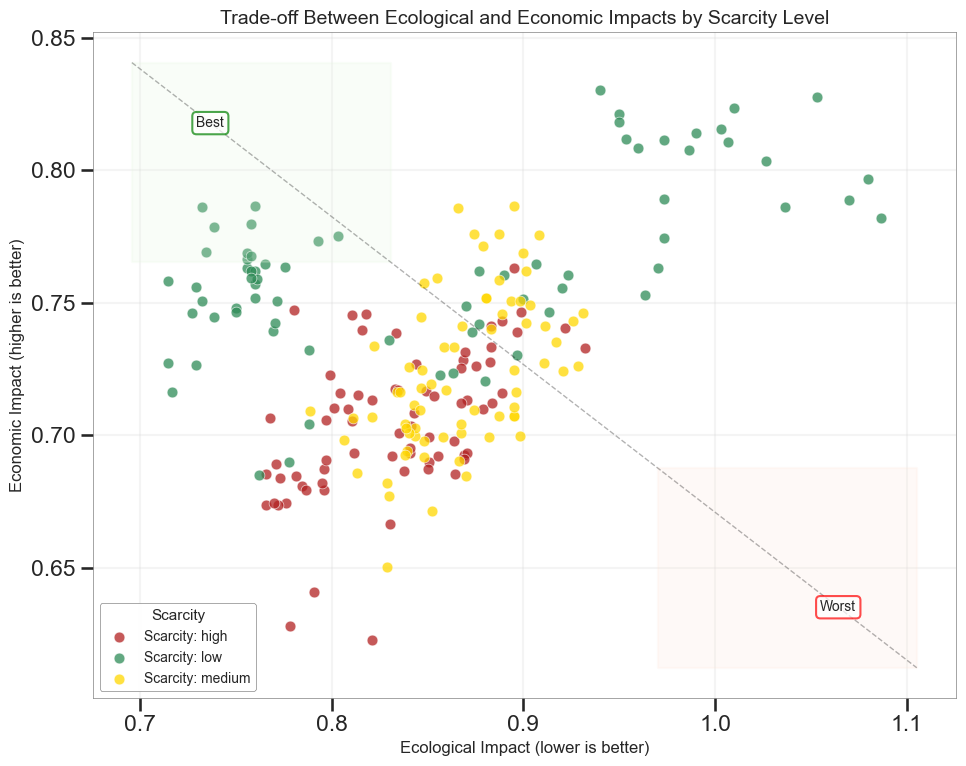

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


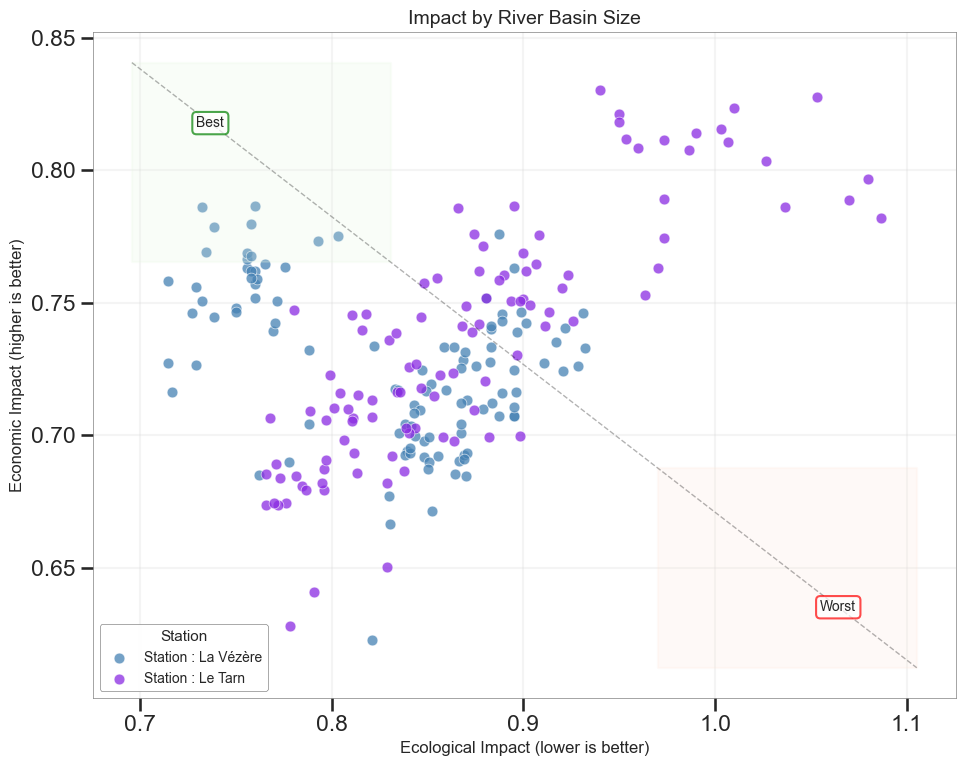

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


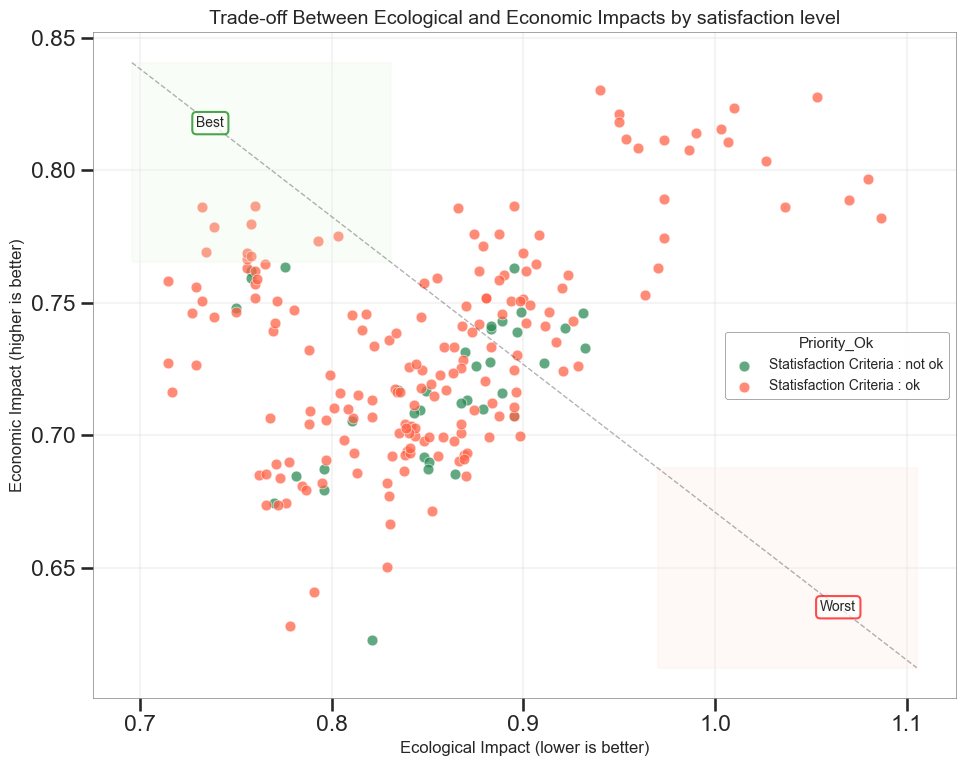

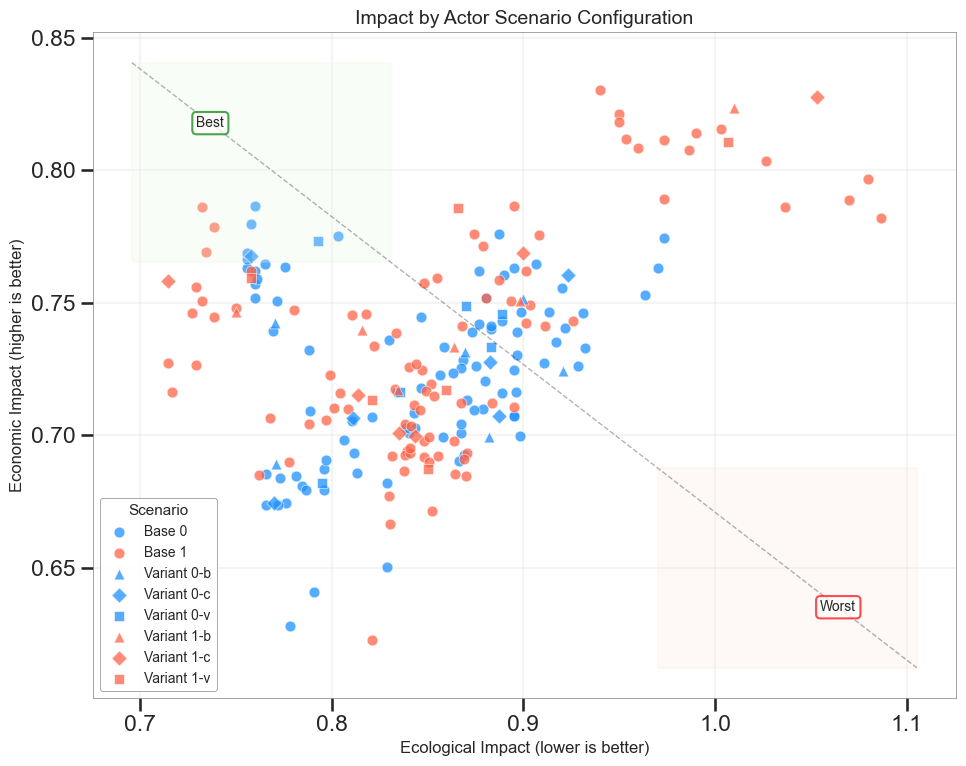

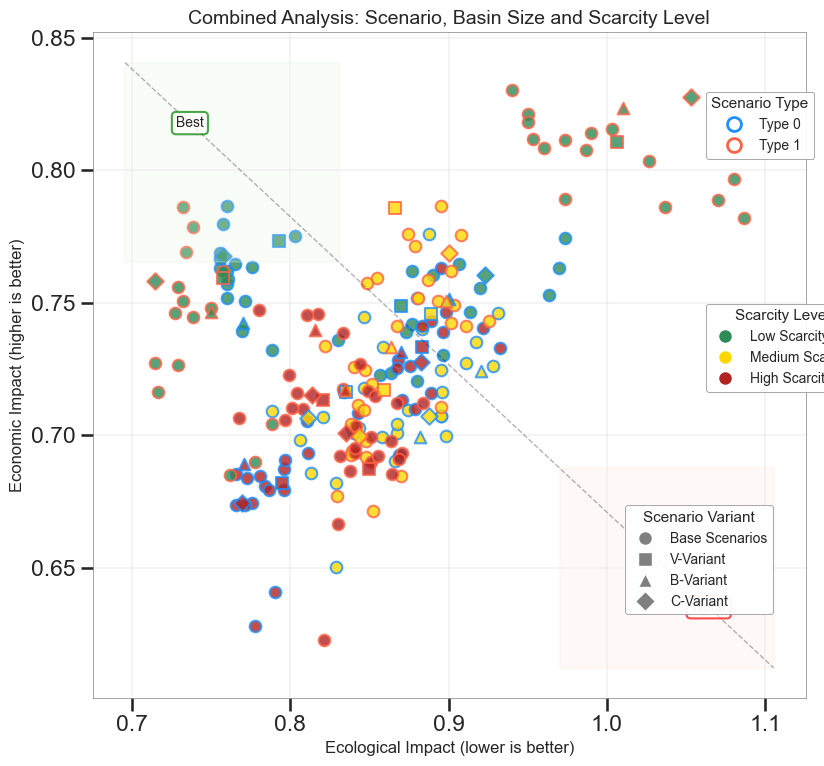

In [12]:
pma.analyze_scenario_impacts(viz_df, is_scalled=True)

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


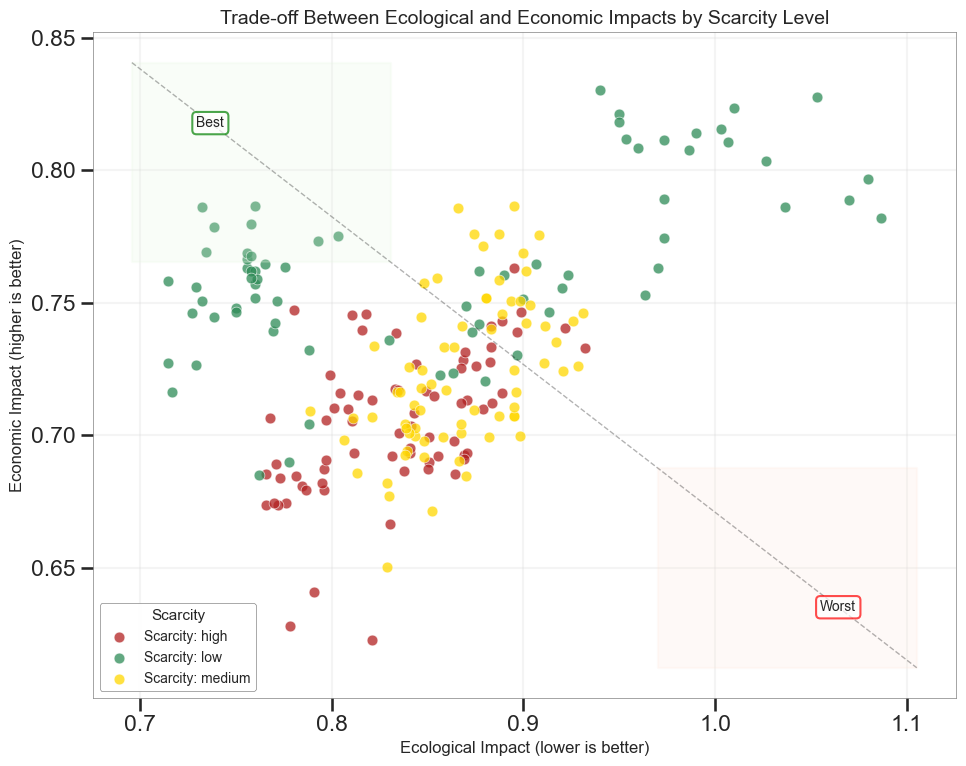

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


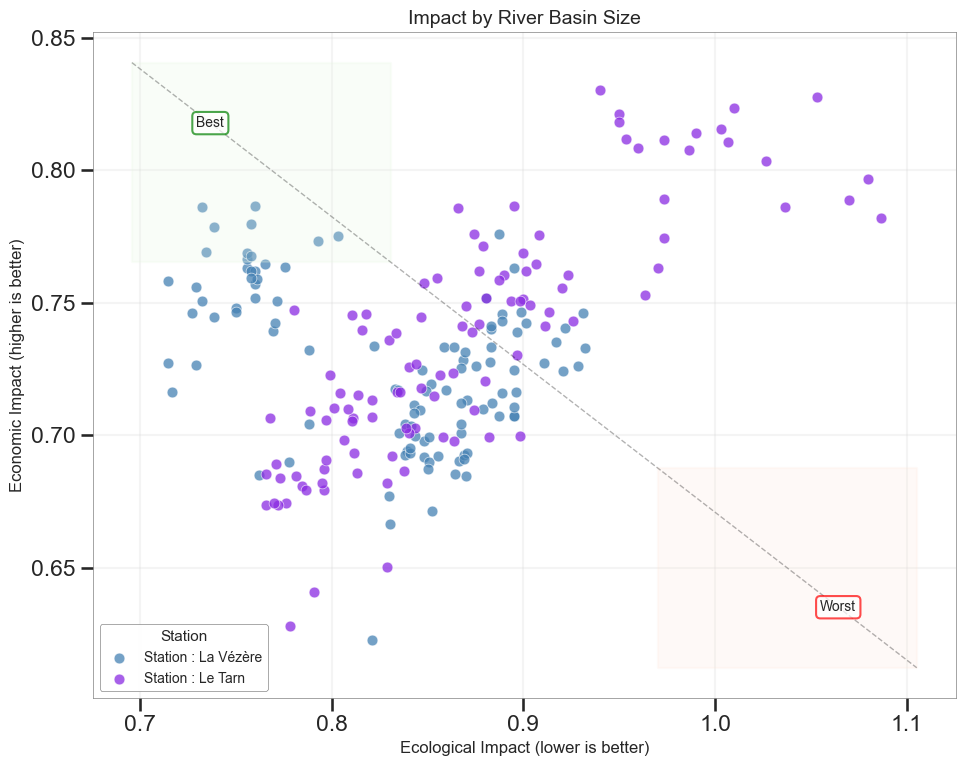

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


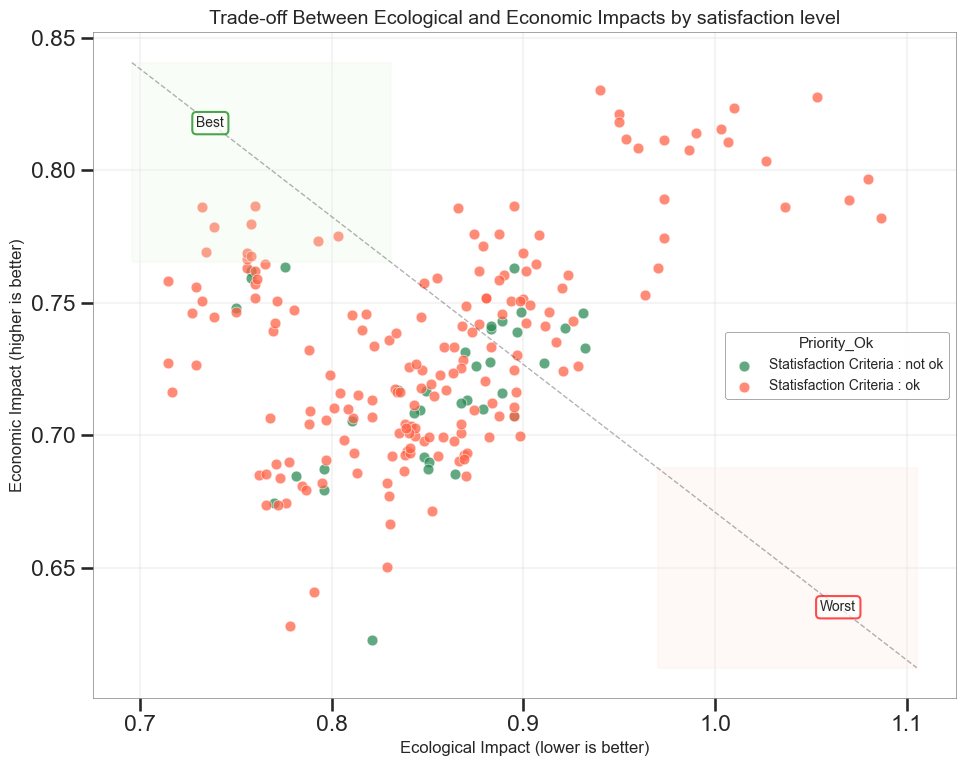

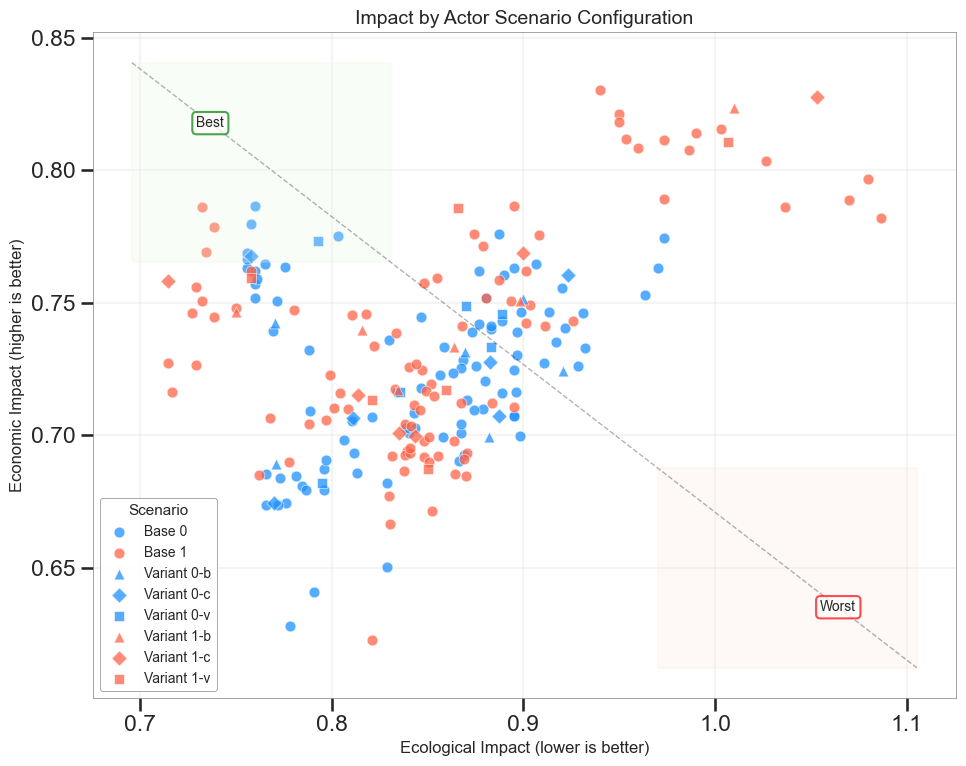

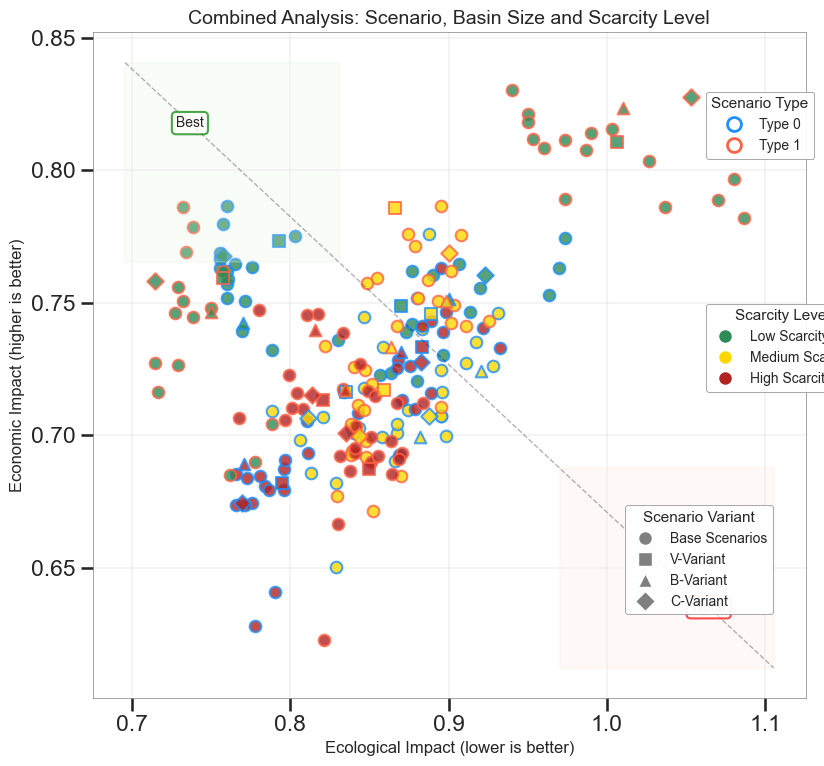

In [13]:
pma.analyze_scenario_impacts(results_df , is_scalled=True)

## Analyzing Forecast Bias & Uncertainty & Scarcity levels

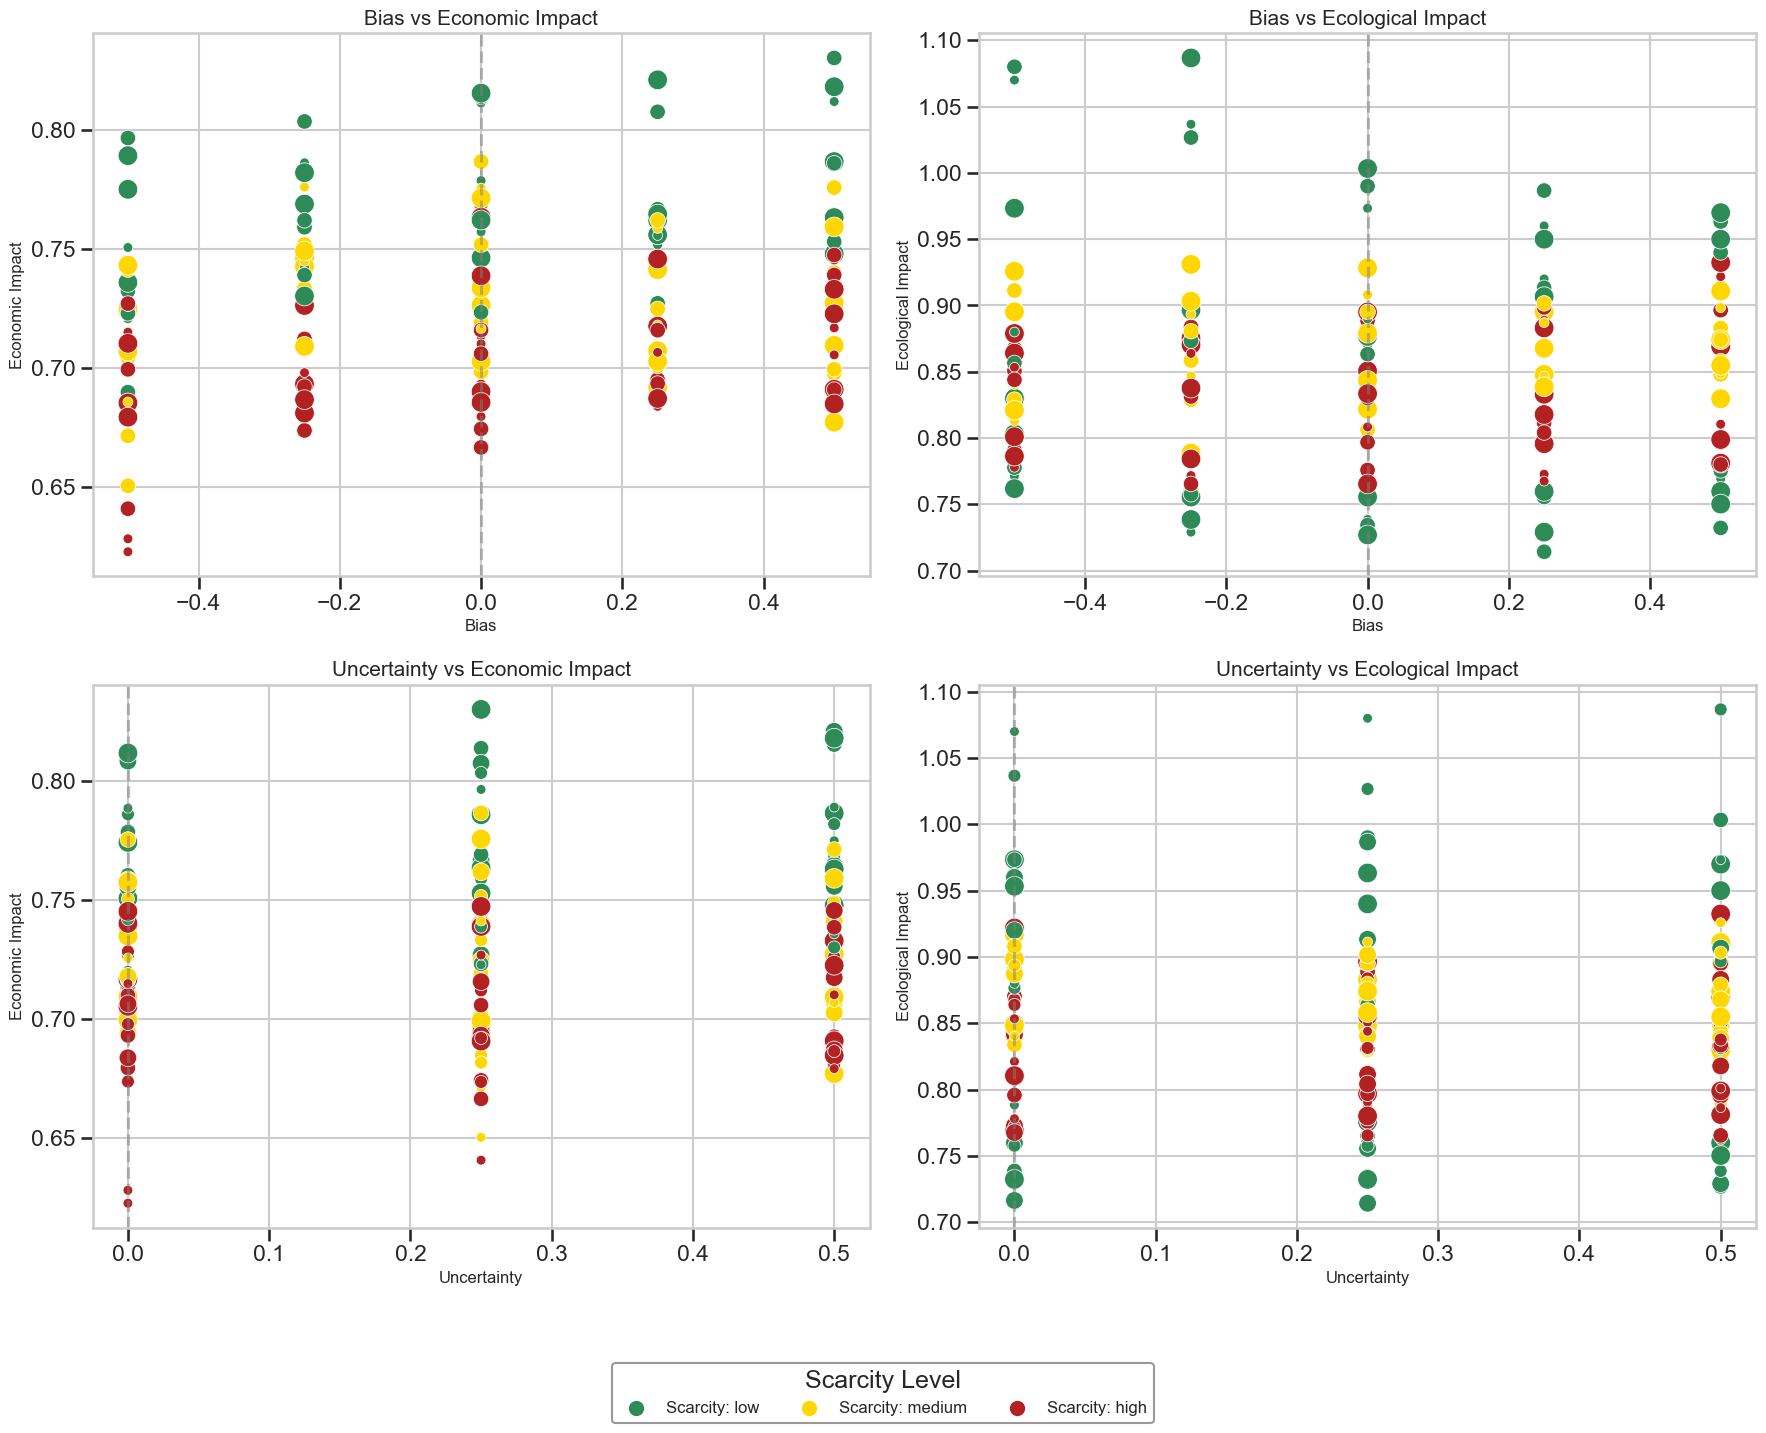

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


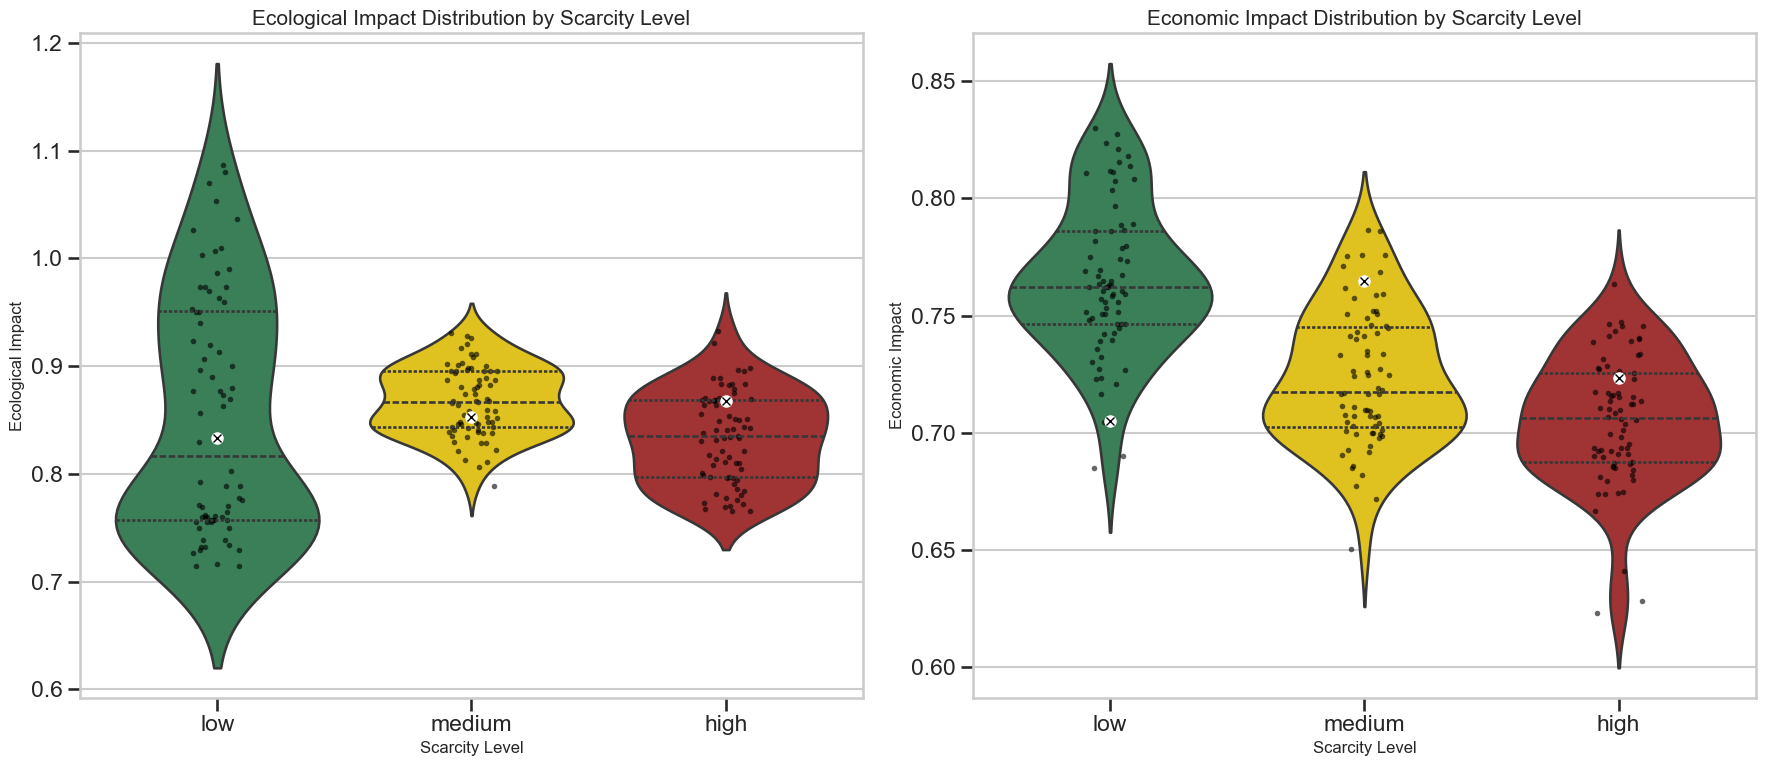

In [14]:
pma.analyze_forecast_effects(results_df, is_scalled=True)

## Correlation Analysis


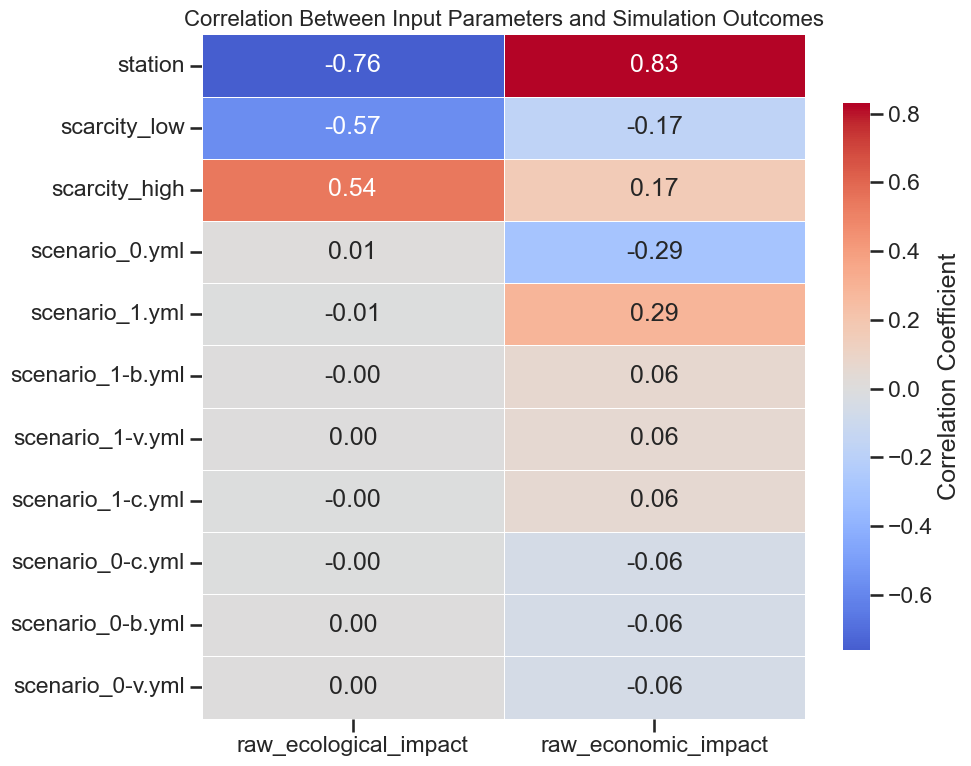


Top impacts on raw_ecological_impact:

Top 5 positive correlations:
  scarcity_high: 0.542
  scarcity_medium: 0.027
  scenario_0.yml: 0.007
  uncertainty: 0.006
  scenario_0-b.yml: 0.004

Top 5 negative correlations:
  scenario_0-c.yml: -0.002
  scenario_1-c.yml: -0.004
  scenario_1.yml: -0.006
  scarcity_low: -0.569
  station: -0.761

Top impacts on raw_economic_impact:

Top 5 positive correlations:
  station: 0.832
  scenario_1.yml: 0.287
  scarcity_high: 0.166
  scenario_1-b.yml: 0.061
  scenario_1-v.yml: 0.060

Top 5 negative correlations:
  scenario_0-v.yml: -0.057
  scenario_0-b.yml: -0.057
  scenario_0-c.yml: -0.057
  scarcity_low: -0.171
  scenario_0.yml: -0.289


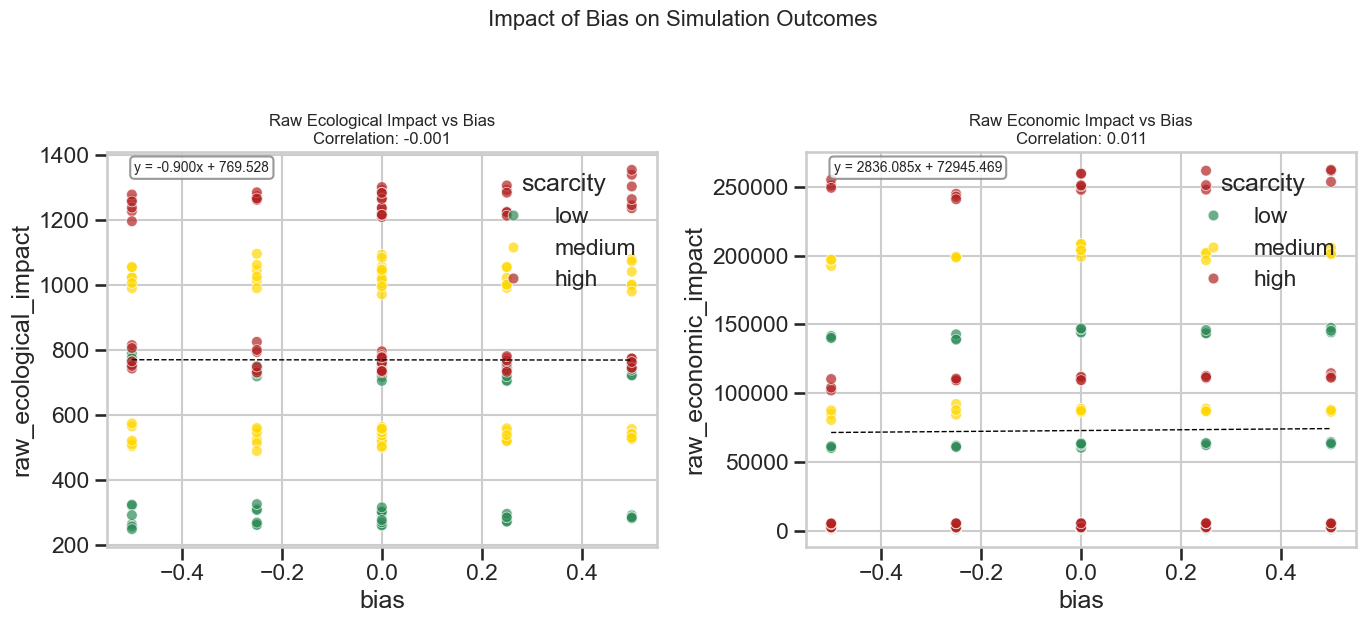

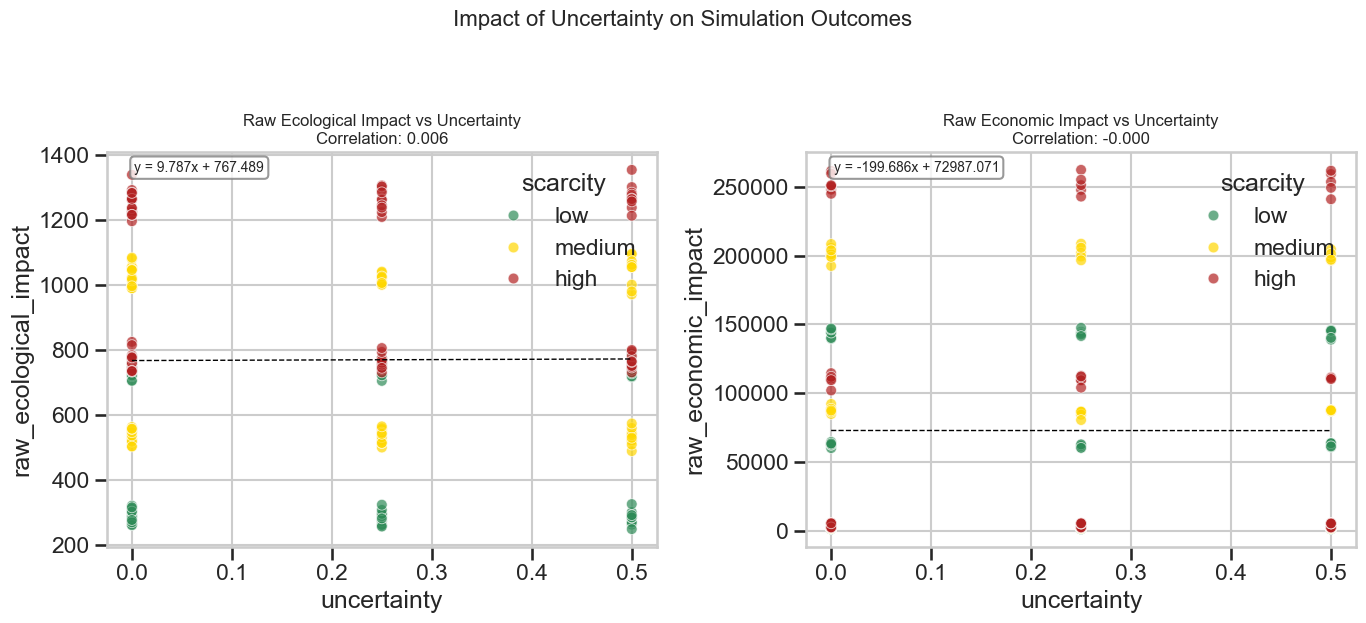

<Figure size 1200x1000 with 0 Axes>

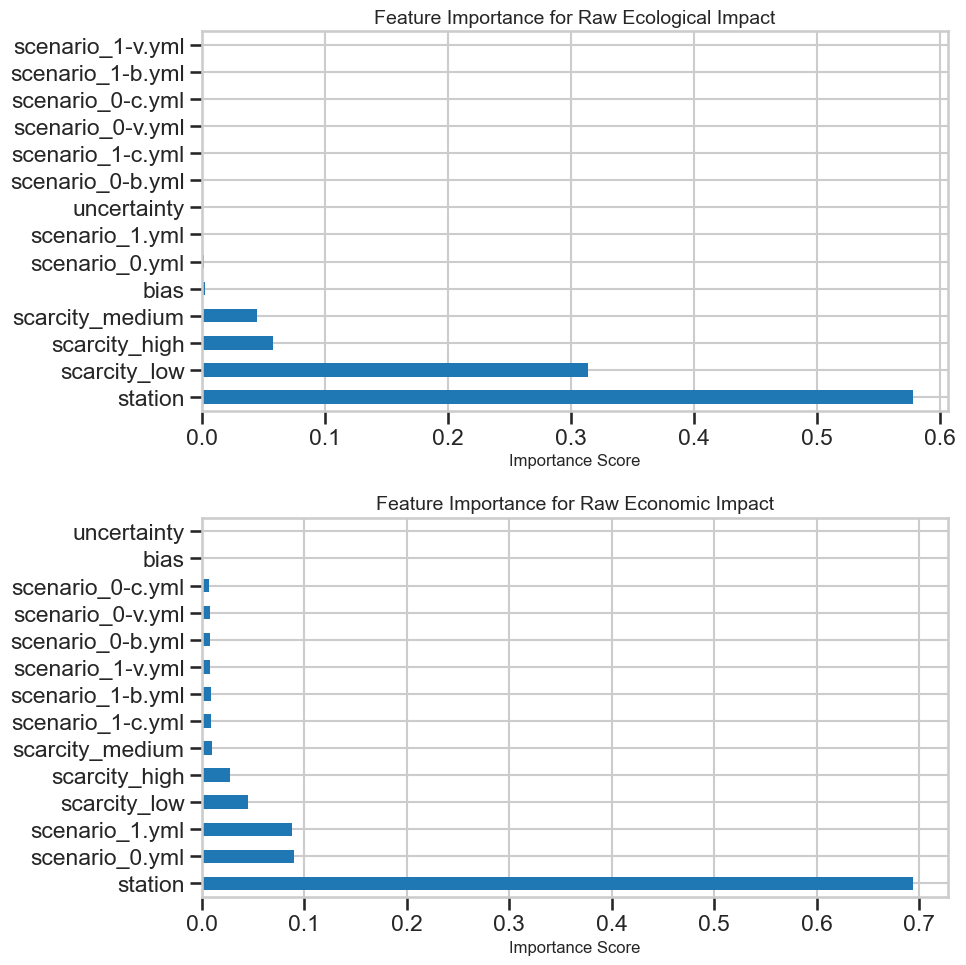

In [15]:
pma.correlation_analysis(results_df)

## Cooperation Analysis
Analyzing cooperation patterns across scenarios and their impact on ecological and economic outcomes.

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:993: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


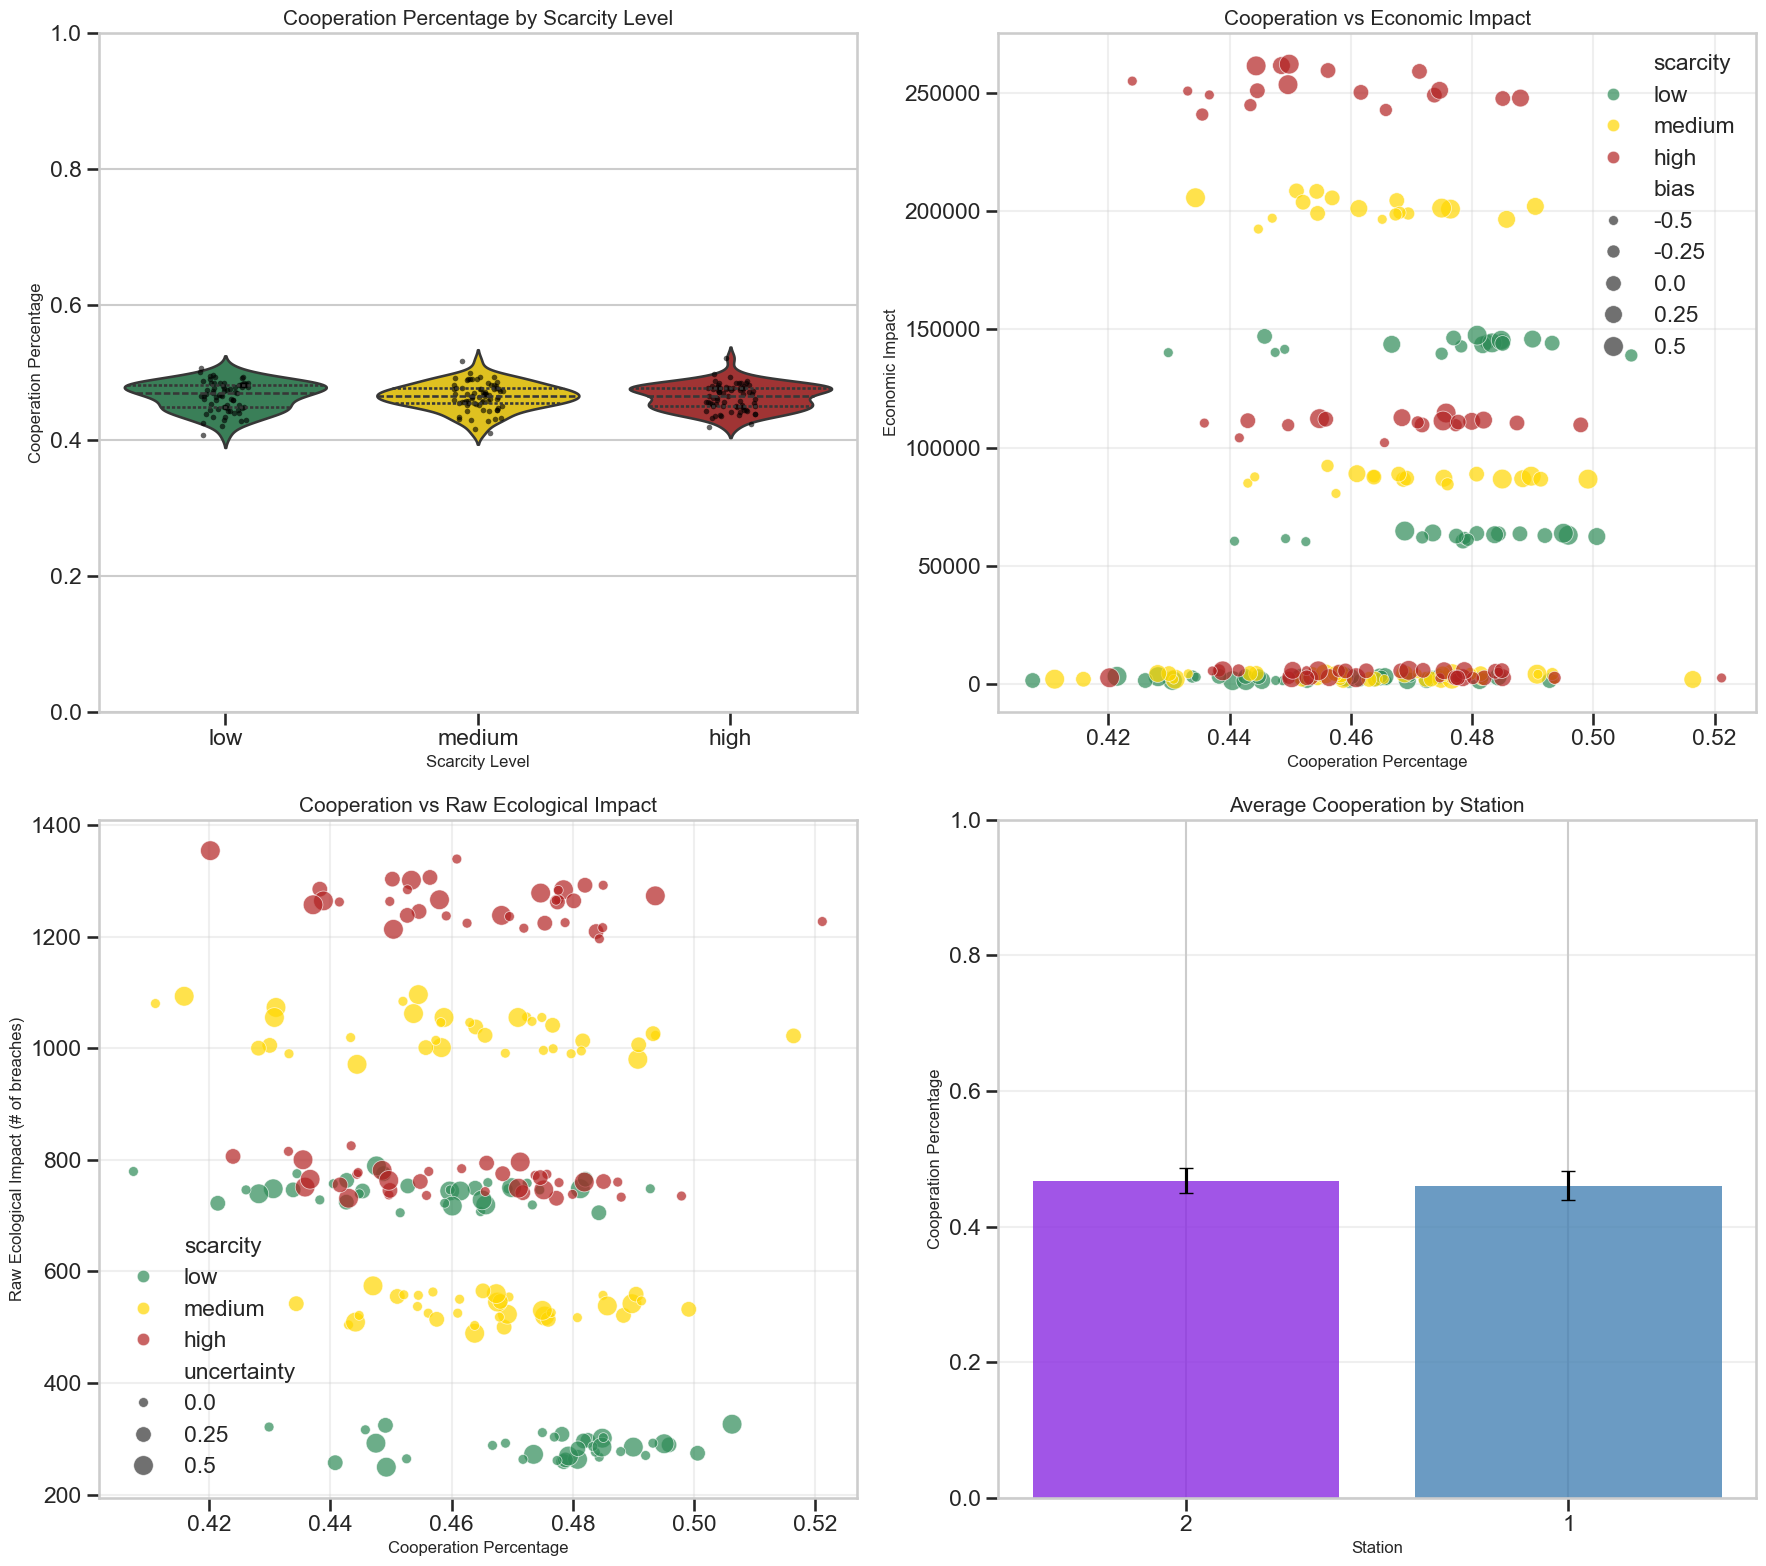

In [16]:
pma.analyze_cooperation_patterns(results_df)

## Raw Impact Vs Scalled Impact
Analyzing the raw (unscaled) ecological / economic impact against scalled impacts 

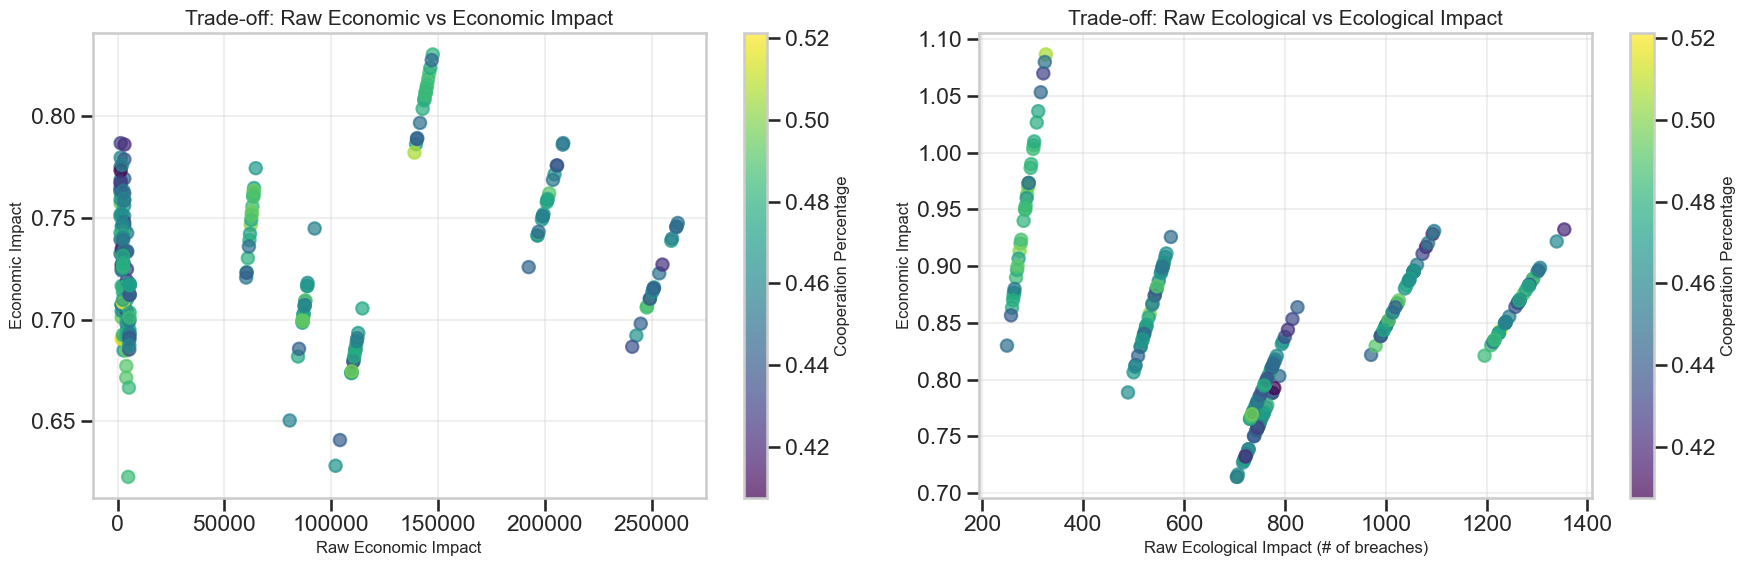

In [17]:
pma.analyze_raw_impact(results_df)

## Cooperation by Forecast Parameters
Analyzing how forecast bias and uncertainty affect cooperation levels.


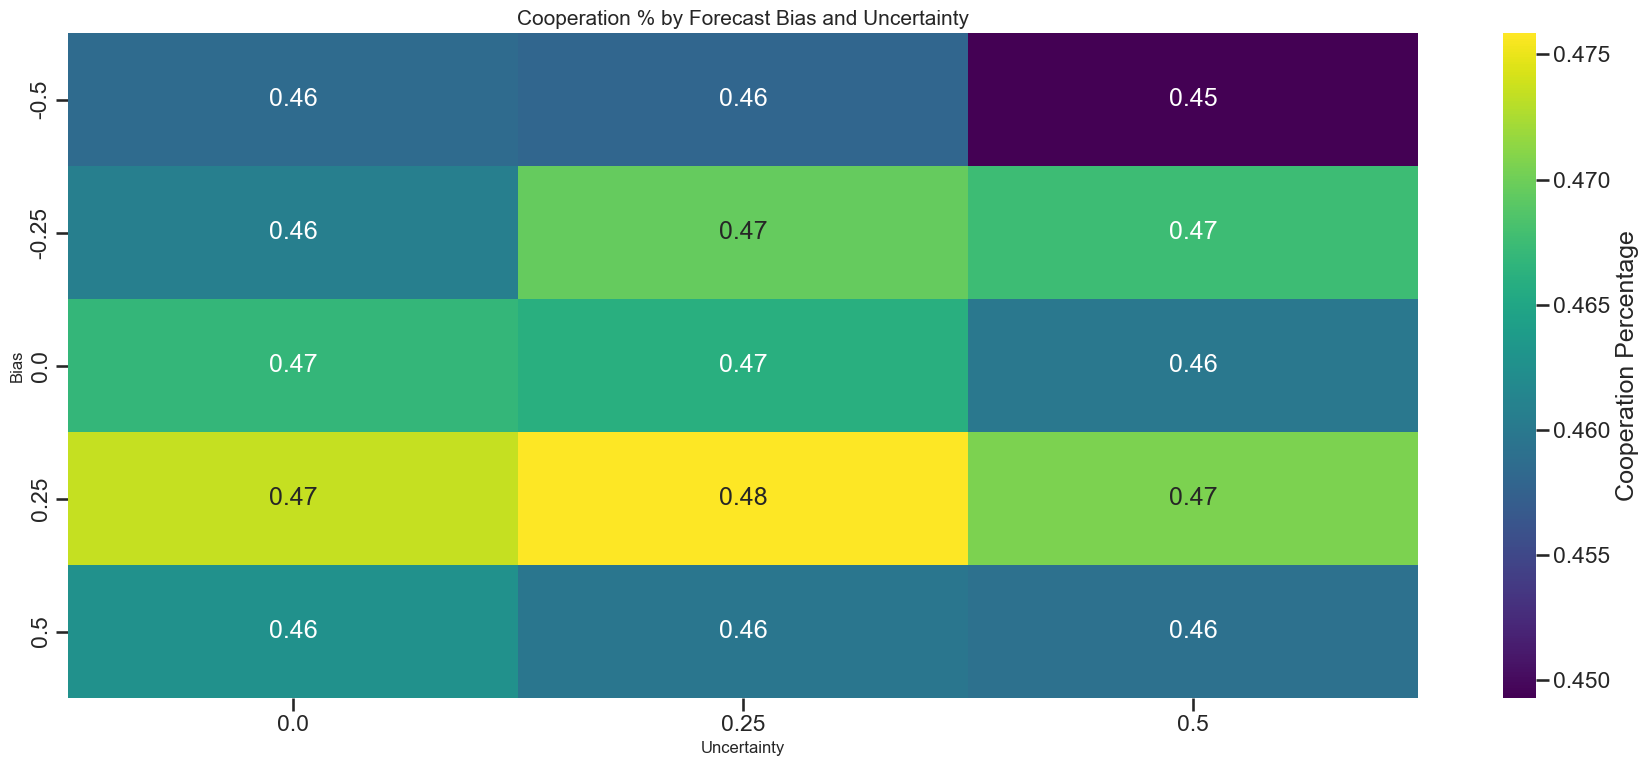

In [18]:
pma.analyze_cooperation_by_forecast_params(results_df)

## Comprehensive Analysis
Performing a comprehensive analysis of all metrics and their relationships.


=== Summary Statistics ===

Overall Metrics:
Average Cooperation: 0.46
Average Raw Ecological Impact: 769.5 breaches
Average Scaled Ecological Impact: 0.851
Average Economic Impact: 72945.469

Correlation Matrix:
                        cooperation_percentage  raw_ecological_impact  \
cooperation_percentage                    1.00                  -0.17   
raw_ecological_impact                    -0.17                   1.00   
ecological_impact                         0.18                  -0.22   
economic_impact                          -0.06                  -0.47   
raw_economic_impact                       0.02                  -0.50   
bias                                      0.12                  -0.00   
uncertainty                              -0.08                   0.01   

                        ecological_impact  economic_impact  \
cooperation_percentage               0.18            -0.06   
raw_ecological_impact               -0.22            -0.47   
ecological_impac

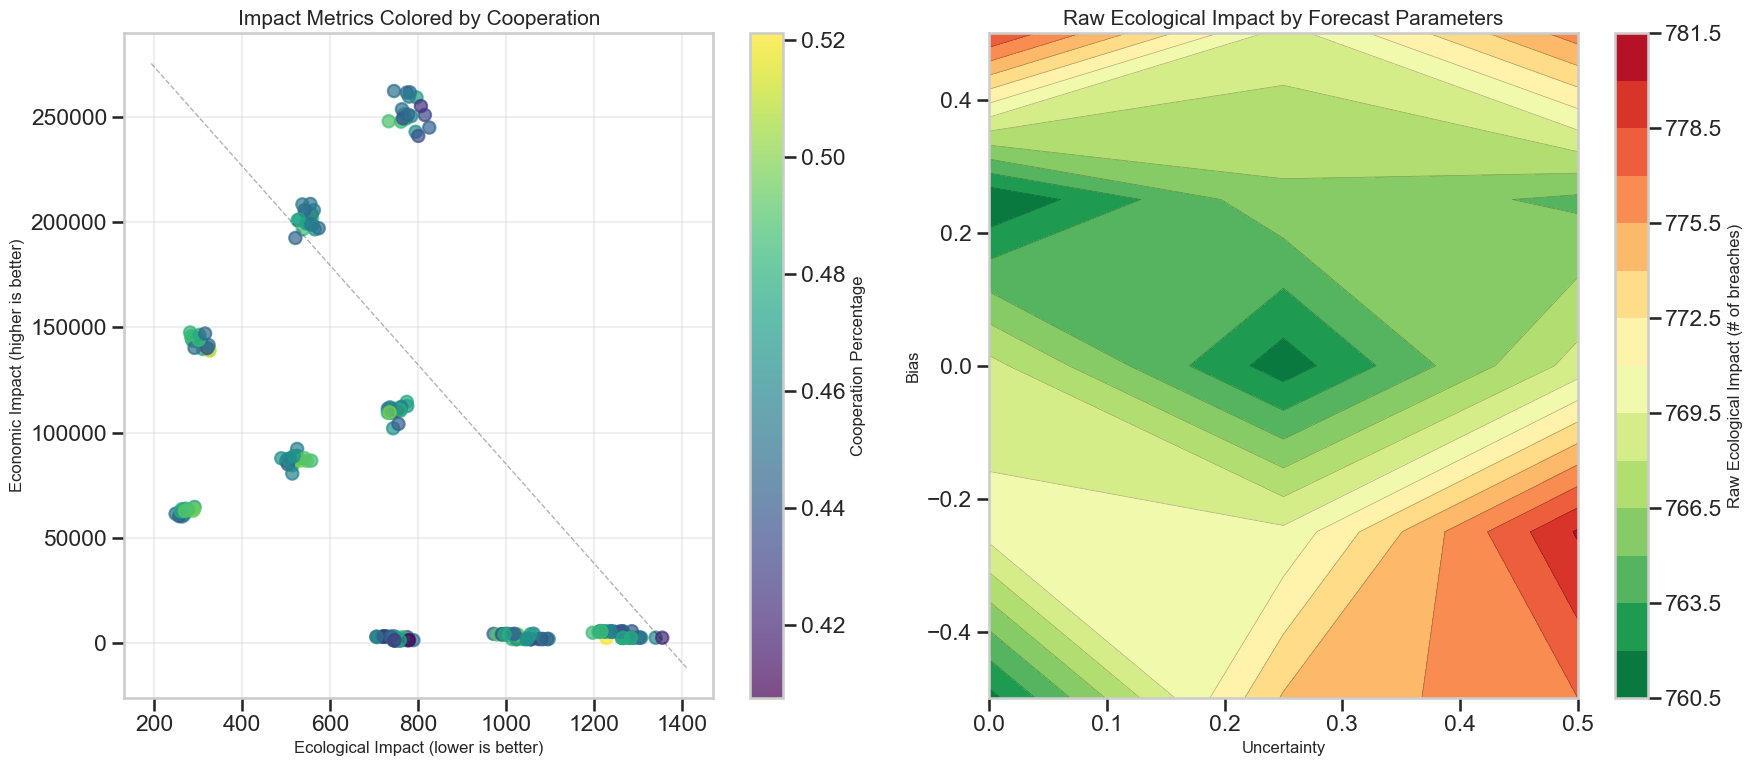

In [19]:
pma.comprehensive_analysis(results_df)

## Conclusion
This notebook has demonstrated how to analyze water allocation policies across multiple scenarios,
focusing on the balance between ecological and economic impacts. To participate in the hackathon:

1. Design your own adaptive policy by modifying the `custom_incentive_policy` and `custom_quota` functions
2. Test your policy across multiple scenarios using the tools provided
3. Optimize your policy to balance ecological integrity and economic benefits

Good luck!